# Mathematical Transforms

- numerical features 간의 관계는 종종 수학적 공식을 통해 표현된다.(일반 숫자처럼 산술 연산하여 column에 적용 가능)
    - 예를 들어, 비율을 계산하여 새로운 파생변수 생성

- 특히 데이터 시각화에서, "reshaping" 은 feature의 변환, 거듭 제곱 또는 로그 등의 형태로 제안한다. 즉 풀어서 설명하자면, 아래 그림과 같다. windspeed의 분포가 매우 작은 구역에서 모여있을 때, 이를 로그를 씌워줌으로써 분포를 고르게 한다.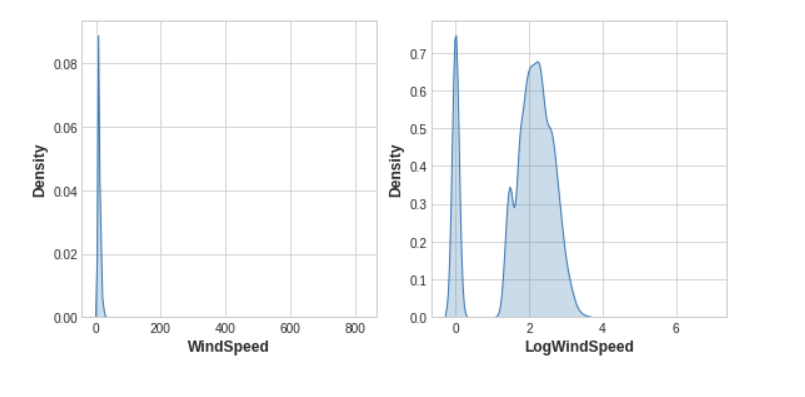

- 변수가 0.0값일 때, np.log 대신 np.log1p 을 사용하면 된다!!

In [5]:
import pandas as pd

df = pd.read_csv('data/ames.csv')

In [6]:
df.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea          float64
Street            object
                  ...   
MoSold             int64
YearSold           int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 79, dtype: object

- `pd.factorize()` :  2가지 값을 반환한다.
        - 첫번째 값은 정수로 인코딩된 값, 두번째 값은 인코딩된 범주

In [12]:
df['MSZoning'].factorize()

(array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'))

In [11]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


def score_dataset(X, y, model=XGBRegressor()):
    # 카테고리 변수 관련해서 label encoding
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [7]:
# 종속변수 분리
X = df.copy()
y = X.pop("SalePrice")

## 1. Create Mathematical Transforms 

- LivLotRatio: the ratio of GrLivArea to LotArea
- Spaciousness: the sum of FirstFlrSF and SecondFlrSF divided by TotRmsAbvGrd
- TotalOutsideSF: the sum of WoodDeckSF, OpenPorchSF, EnclosedPorch, Threeseasonporch, and ScreenPorch

In [8]:
#DF 생성
X_1 = pd.DataFrame()

X_1["LivLotRatio"] = df.GrLivArea / df.LotArea
X_1["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
X_1["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch + df.ScreenPorch
X_1

,LivLotRatio,Spaciousness,TotalOutsideSF
0,0.052125,236.571429,272.0
1,0.077095,179.200000,260.0
2,0.093152,221.500000,429.0
3,0.189068,263.750000,0.0
4,0.117787,271.500000,246.0
...,...,...,...
2925,0.126370,167.166667,120.0
2926,0.101519,180.400000,164.0
2927,0.092903,161.666667,112.0
2928,0.138761,231.500000,278.0


## 2. Categorical 변수 처리

- `pd.get_dummies` : 더미변수 생성
- BldgType and GrLivArea 의 관계를 표현하기 위해 더미변수로 처리한 후 ,GrLivArea 만큼 곱해줌 : `mul`

In [9]:
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
X_2

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
2925,0,1,0,0,0
2926,0,1,0,0,0
2927,0,1,0,0,0
2928,0,1,0,0,0


In [10]:
X_2.mul(df.GrLivArea, axis=0)

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0
...,...,...,...,...,...
2925,0.0,1003.0,0.0,0.0,0.0
2926,0.0,902.0,0.0,0.0,0.0
2927,0.0,970.0,0.0,0.0,0.0
2928,0.0,1389.0,0.0,0.0,0.0


## 3. Count Feature

- `gt(0.0)` : 각 행별로 변수값이 0이상인 boolean을 나타내는 변수 생성

In [18]:
X_3 = pd.DataFrame()

X_3["PorchTypes"] = df[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]].gt(0.0).sum(axis=1)

In [19]:
df[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]]

,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch
0,210.0,62.0,0.0,0.0,0.0
1,140.0,0.0,0.0,0.0,120.0
2,393.0,36.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,212.0,34.0,0.0,0.0,0.0
...,...,...,...,...,...
2925,120.0,0.0,0.0,0.0,0.0
2926,164.0,0.0,0.0,0.0,0.0
2927,80.0,32.0,0.0,0.0,0.0
2928,240.0,38.0,0.0,0.0,0.0


In [20]:
df[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]].gt(0.0)

,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch
0,True,True,False,False,False
1,True,False,False,False,True
2,True,True,False,False,False
3,False,False,False,False,False
4,True,True,False,False,False
...,...,...,...,...,...
2925,True,False,False,False,False
2926,True,False,False,False,False
2927,True,True,False,False,False
2928,True,True,False,False,False


## 4. categorical 변수 string을 split하여 파생변수 생성

In [55]:
df.MSSubClass.unique()

array(['One_Story_1946_and_Newer_All_Styles', 'Two_Story_1946_and_Newer',
       'One_Story_PUD_1946_and_Newer',
       'One_and_Half_Story_Finished_All_Ages', 'Split_Foyer',
       'Two_Story_PUD_1946_and_Newer', 'Split_or_Multilevel',
       'One_Story_1945_and_Older', 'Duplex_All_Styles_and_Ages',
       'Two_Family_conversion_All_Styles_and_Ages',
       'One_and_Half_Story_Unfinished_All_Ages',
       'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages',
       'One_Story_with_Finished_Attic_All_Ages',
       'PUD_Multilevel_Split_Level_Foyer',
       'One_and_Half_Story_PUD_All_Ages'], dtype=object)

In [36]:
# n 개수만큼 생성
# expand=True : df형식으로 유지
cus=pd.DataFrame()
cus[['2','type','level']] = df.MSSubClass.str.split("_", n=2, expand=True)
cus

,2,type,level
0,One,Story,1946_and_Newer_All_Styles
1,One,Story,1946_and_Newer_All_Styles
2,One,Story,1946_and_Newer_All_Styles
3,One,Story,1946_and_Newer_All_Styles
4,Two,Story,1946_and_Newer
...,...,...,...
2925,Split,or,Multilevel
2926,One,Story,1946_and_Newer_All_Styles
2927,Split,Foyer,None
2928,One,Story,1946_and_Newer_All_Styles


- `transform` : agg 하는것이 아니라 각 행에 파생변수 생성시 유의미함!!!

```customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)```

customer[["State", "Income", "AverageIncome"]].head(10)

# TIP

- Linear model과 뉴럴넷은 normalized feature 사용 시 일반적으로 성능 좋음!
- tree 모델을 생성할 때, Count 집계 매우 유의!!!